In [1]:
!pip install pyarrow

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install evidently

Defaulting to user installation because normal site-packages is not writeable


In [4]:
!pip install shap

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import pandas as pd
import numpy as np
import pickle
import shap

from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://n

In [15]:
model = pickle.load(open("/home/jupyter/notebooks/modeling/mlruns/153868194415307648/111380cf59d34cf7acaebea10d1e32fa/artifacts/best_estimator/model.pkl", "rb"))

In [16]:
df_train = pd.read_parquet("../working/df_application_train.parquet")

In [17]:
df_test = pd.read_parquet("../working/df_application_test.parquet")

In [18]:
proba = model.predict_proba( df_test.drop(columns="SK_ID_CURR") )

In [19]:
proba.shape

(48744, 2)

In [20]:
df_test.shape

(48744, 513)

In [21]:
def get_target(p):
    return 1 if p[1]>0.49 else 0

In [22]:
df_test["TARGET"] = np.apply_along_axis(get_target, 1, proba)

In [23]:
X = np.array(df_train.drop(columns="SK_ID_CURR"), dtype=float)
explainer = shap.Explainer(model, X, feature_names=df_train.drop(columns="SK_ID_CURR").columns)
shap_values = explainer(X)

100%|===================| 307439/307511 [28:21<00:00]        

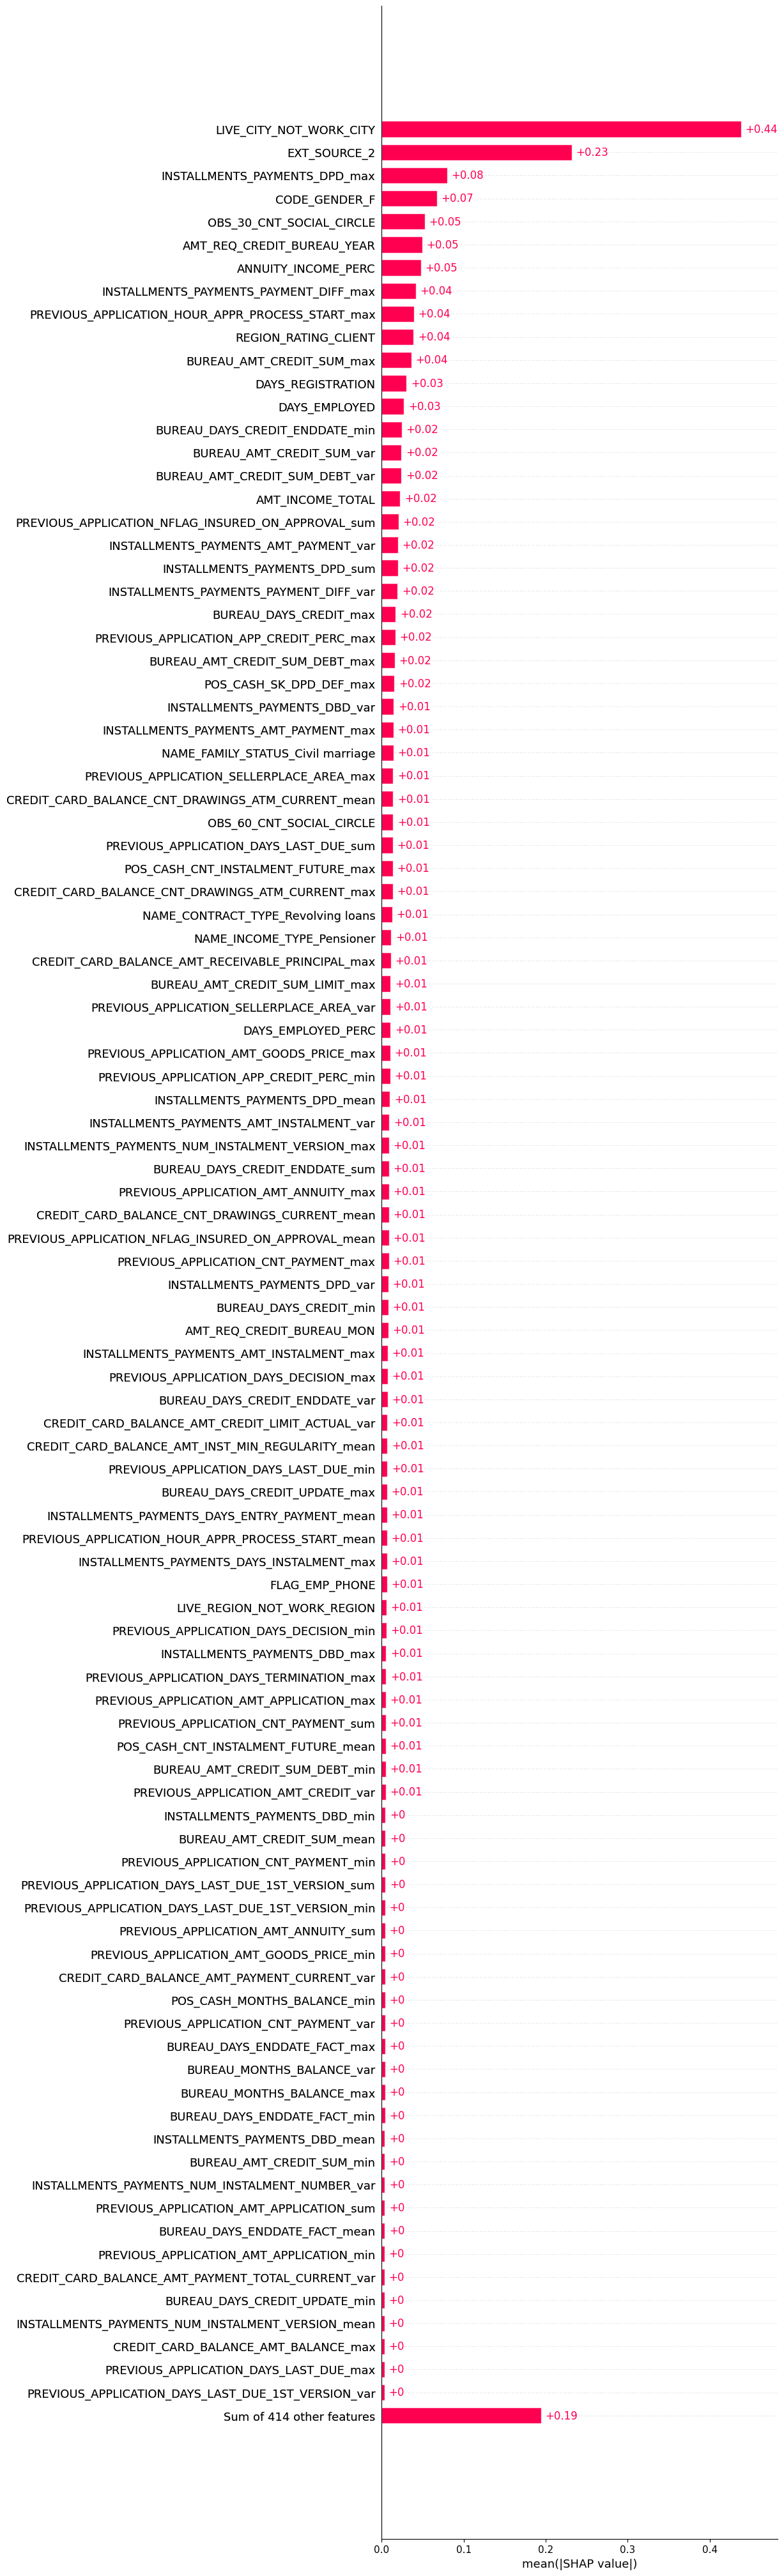

In [24]:
shap.plots.bar(shap_values, max_display=100)


In [26]:
vals = np.abs(shap_values.values).mean(0)
feature_importance = pd.DataFrame(
    list(zip(df_train.drop(columns="SK_ID_CURR").columns, vals)),
    columns=['col_name', 'feature_importance_vals']
)
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)

In [27]:
feature_importance.loc[feature_importance["feature_importance_vals"]>=.005].shape

(73, 2)

In [28]:
feature_importance.loc[feature_importance["feature_importance_vals"]>=0.005]['feature_importance_vals'].sum()

1.863420394644437

In [29]:
feature_importance['feature_importance_vals'].sum()

2.1659173391833875

In [30]:
100 * feature_importance.loc[feature_importance["feature_importance_vals"]>=0.005]['feature_importance_vals'].sum() / feature_importance['feature_importance_vals'].sum()

86.03377243136156

En prenant les 73 premières features qui expliquent le modèle de manière globale, on peut expliquer 86% des variations du modèle.

In [31]:
reference = df_train.loc[:, feature_importance.loc[feature_importance["feature_importance_vals"]>=.005]["col_name"].to_list() + ["TARGET"] ].sample(n=10000, replace=False)
current = df_test.loc[:, feature_importance.loc[feature_importance["feature_importance_vals"]>=.005]["col_name"].to_list() + ["TARGET"] ].sample(n=10000, replace=False)

In [32]:
report = Report(metrics=[
    DataDriftPreset(), 
])

report.run(reference_data=reference, current_data=current)


In [33]:
report.save_html("report_data_drift-80.html")

In [34]:
from IPython.display import display, HTML

with open("report_data_drift-80.html", "r") as f:
    display(HTML(f.read()))